In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import evosax

import json


In [4]:
import xylo
import xylo.types as t
import xylo.woods
import xylo.cut

import xylo.opt

import xylo.tuning
import xylo.database
import xylo.just

In [5]:
layout = xylo.just.bass_partch
bar_thick = xylo.types.BarProps(width = 0.090, min_depth=0.002, depth=0.020, length = 1.000, elements = 10)

wood = 'prad'

# 35
if wood == 'ore':
  mat = xylo.woods.oregon_pine
  depth = 35
# 50
elif wood == 'ngr':
  mat = xylo.woods.new_guinea_rosewood
  depth = 50
# 53
elif wood == 'pad':
  mat = xylo.woods.african_padauk
  depth = 53
# 40
elif wood == 'bwd':
  mat = xylo.woods.blackwood
  depth = 40
elif wood == 'prad':
  mat = xylo.woods.pinus_radiata
  depth = 40
else:
  mat = xylo.woods.spotted_gum
  depth = 30

tuning = xylo.tuning.yamaha_YX500R

In [60]:
def mk_geom(note):
  bar = bar_thick
  return xylo.database.Geometry(width = bar.width * 1000, length = bar.length * 1000, depth = depth, weight = 1)

geom0 = { k: mk_geom(k) for k in layout.rows.keys() }

# geom0 = xylo.just.diamond_11_partch_geom

def get_db():
  return xylo.database.get(geom0, f'data/db-bass-{wood}-d{depth}.json')
def with_db(act):
  return xylo.database.with_db(act, geom0, f'data/db-bass-{wood}-d{depth}.json')

def get_bar(note, elts):
  b = get_db().get_bar(note, elements = elts, min_depth_abs=0.005)
  return b

In [61]:
with_db(lambda db: db.clear_loss_all())

In [62]:
geom0

{'A#3': Geometry(length=1000.0, width=90.0, depth=40, weight=1),
 'A3': Geometry(length=1000.0, width=90.0, depth=40, weight=1),
 'F#3': Geometry(length=1000.0, width=90.0, depth=40, weight=1),
 'F3': Geometry(length=1000.0, width=90.0, depth=40, weight=1),
 'D#3': Geometry(length=1000.0, width=90.0, depth=40, weight=1),
 'C#3': Geometry(length=1000.0, width=90.0, depth=40, weight=1),
 'A2': Geometry(length=1000.0, width=90.0, depth=40, weight=1),
 'G2': Geometry(length=1000.0, width=90.0, depth=40, weight=1),
 'E2': Geometry(length=1000.0, width=90.0, depth=40, weight=1),
 'D2': Geometry(length=1000.0, width=90.0, depth=40, weight=1),
 'C2': Geometry(length=1000.0, width=90.0, depth=40, weight=1)}

In [63]:
init_mean = None
sum_lengths = 0
for num_dims in [5]: # range(3,10):
  for elts in [20, 30, 50]: # range(20, 200, 10):
    options = xylo.opt.Options(num_generations = 10, strategy = evosax.OpenES(popsize = 2000, num_dims = num_dims), absolute_tolerance = 1e-5)

    for note in ['G2']: # layout.rows.keys():
      db = get_db()
      match db.get_best_for_dims(note, num_dims):
        case None:
          pass
        case e:
          init_mean = e

      options_ = options._replace(init_mean = init_mean)
      # options_ = options

      bar = get_bar(note, elts)
      # bar = bar_default._replace(length = len)
      # bar = t.BarProps(width = 0.) db.get_bar(note)
      # wood = db.get_wood(note)

      freq = layout.reference_hz * layout.rows[note]
      partials = [1.0, 4.0, 8.0]
      weights = [tuning.weight(freq), tuning.weight(freq * partials[1]) * 0.5, tuning.weight(freq * partials[2]) * 0.25]

      sol = xylo.opt.optimize_geometry_length(bar, mat, options_, freq, jnp.array(partials), jnp.array(weights), weight_len=0.2)
      spline = sol.best_member

      # only if looping through multiple elts
      # with_db(lambda db: db.clear_loss(note))

      with_db(lambda db: db.set_best_for_dims(note, num_dims, sol.best_member.tolist(), sol.best_fitness.tolist()))

      init_mean = sol.best_member

      spline, len = init_mean[0:-1], init_mean[-1]
      # spline, len = init_mean, 1
      barx = bar._replace(length = bar.length * len)
      section = xylo.cut.spline(barx, spline)
      swp = xylo.sweep.sweep(mat, barx, section, t.sweep_default)

      sum_lengths += barx.length

      print(note, freq)
      print("---------------")
      print(swp.harmonics / freq, barx.length, init_mean)
      print("")

print("total length: ", sum_lengths)

iteration 0
[0.02698345 0.79279576 0.02410747 0.89044719 0.43721071] 0.13058722
[ 97.51469914 405.25753117 717.07999233] [0.99504795 4.13528093 7.31714278] 0.4372107136315299
G2 98.0
---------------
[0.99807229 3.98933618 7.79741045] 0.42851453670442374 [0.         0.81874557 0.         0.81915578 0.42851454]

iteration 0
[0.01765925 0.77580092 0.01272442 0.81933546 0.43353427] 0.10674808
[ 98.22938064 388.64760449 741.84242935] [1.00234062 3.96579188 7.56982071] 0.4335342707749496
G2 98.0
---------------
[1.00234062 3.96579188 7.56982071] 0.4335342707749496 [0.01765925 0.77580092 0.01272442 0.81933546 0.43353427]

iteration 0
[0.0160185  0.80940846 0.         0.83733995 0.4244232 ] 0.099508576
[ 97.88683706 391.12888935 744.6575749 ] [0.99884528 3.99111112 7.59854668] 0.4244231966487546
G2 98.0
---------------
[0.99884528 3.99111112 7.59854668] 0.4244231966487546 [0.0160185  0.80940846 0.         0.83733995 0.4244232 ]

total length:  1.286472004128128


[0.0, 0.8187455731707544, 0.0, 0.819155778637272, 0.42851453670442374]
G2 0.42851453670442374
[0.96165162 3.58631158 6.98064849] 98.0


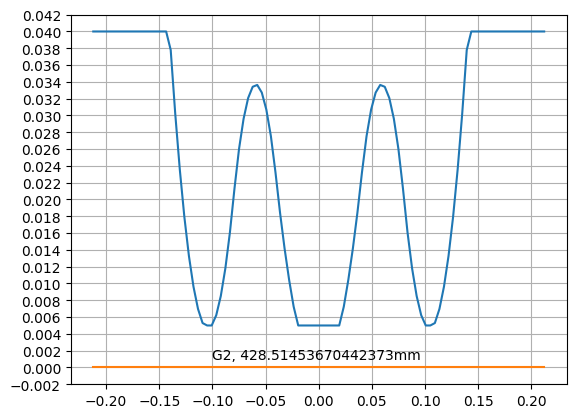

In [64]:
import matplotlib.ticker as plticker
for note in ['G2']: # layout.rows.keys():
  db = get_db()
  bar = get_bar(note, 100)
  fundamental = layout.reference_hz * layout.rows[note]
  len_mul = 0.5
  # params = db.get_best_for_dims(note, 3)
  params = db.get_best(note)['coeff']
  print(params)
  spline, len = params[0:-1], params[-1]

  section = xylo.cut.spline(bar._replace(length = bar.length * len), jnp.array(spline))
  section.plot(to_scale = False)
  print(note, bar.length * len)
  swp = xylo.sweep.sweep(mat, bar, section, t.sweep_default)
  print(swp.harmonics / fundamental, fundamental)
  plt.grid()
  ax = plt.gca()
  locx = plticker.MultipleLocator(base=0.05)
  locy = plticker.MultipleLocator(base=0.002)
  ax.xaxis.set_major_locator(locx)
  ax.yaxis.set_major_locator(locy)
  plt.text(-0.1, 0.001, f"{note}, {bar.length*len*1000}mm")
  # plt.gca()